In [27]:
# Imports for EDA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

In [28]:
# Loading data w/ encoding fix

df = pd.read_csv('../data/raw/startups_data.csv', encoding='latin-1')

## Initial Early Data Overview

**Dataset Size**: 54,294 startups w/ 39 features

**Key Features Confirmed**
- Geographic: country_code, region, city
- Industry: category_list, market
- Funding: funding_total_usd, funding rounds (A-H), funding types
- Temporal: founded_year`, funding dates
- Target: status (acquired/operating/closed)

In [29]:
# Some brief early exploration - rows, columns, column names, first 5 rows 

print(f"Dataset Shape: {df.shape}")
print(f"Columns {df.columns.tolist()}")
print(df.head())


Dataset Shape: (54294, 39)
Columns ['permalink', 'name', 'homepage_url', 'category_list', ' market ', ' funding_total_usd ', 'status', 'country_code', 'state_code', 'region', 'city', 'funding_rounds', 'founded_at', 'founded_month', 'founded_quarter', 'founded_year', 'first_funding_at', 'last_funding_at', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant', 'private_equity', 'post_ipo_equity', 'post_ipo_debt', 'secondary_market', 'product_crowdfunding', 'round_A', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H']
                         permalink                name  \
0            /organization/waywire            #waywire   
1  /organization/tv-communications  &TV Communications   
2    /organization/rock-your-paper   'Rock' Your Paper   
3   /organization/in-touch-network   (In)Touch Network   
4   /organization/r-ranch-and-mine  -R- Ranch and Mine   

                    homepage_url  \
0         

### Data Summary
- **Memory usage**: 16.2 MB - manageable for analysis
- **Critical issue**: funding_total_usd stored as text (object). Needs numeric conversion
- **Missing values**: Temporal features (~29% missing) and geographic data (~18% missing) require strategic handling
- **Good coverage**: Funding rounds and investment types have good completeness (91% non-null)

In [30]:
# Data types, memory usage, amount of non-null values per column

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54294 entries, 0 to 54293
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   permalink             49438 non-null  object 
 1   name                  49437 non-null  object 
 2   homepage_url          45989 non-null  object 
 3   category_list         45477 non-null  object 
 4    market               45470 non-null  object 
 5    funding_total_usd    49438 non-null  object 
 6   status                48124 non-null  object 
 7   country_code          44165 non-null  object 
 8   state_code            30161 non-null  object 
 9   region                44165 non-null  object 
 10  city                  43322 non-null  object 
 11  funding_rounds        49438 non-null  float64
 12  founded_at            38554 non-null  object 
 13  founded_month         38482 non-null  object 
 14  founded_quarter       38482 non-null  object 
 15  founded_year       

In [31]:
# Ignoring warnings
warnings.filterwarnings('ignore')

# Plotting style
plt.style.use('default')
sns.set_palette("husl")

## 1. Data Quality Assessment

### Key Findings

**Missing Data Patterns**
- **Geographic data**: Moderate missing values (18-20% for country/region, 44% for state_code)
- **Temporal data**: Significant gaps (~29% missing founding dates). Could impact our economic cycle analysis
- **Industry data**: Good coverage (16% missing for categories/market)
- **Critical insight**: Missing data appears systematic rather than random. Suggests data collection challenges for certain startup characteristics

**Duplicate Analysis**
- **4,943 duplicate company names** detected (9.1% of total dataset)
- Duplication investigation needed

**Data Type Assessment**
- **23 numeric features** (float64): quantitative analysis
- **16 text features** (object): categorical and funding data that needs cleaning
- **Key issue**: Funding amounts stored as text instead of numeric values

### Implications for ML Pipeline

- Large dataset size (54,294 companies)
- Rich feature set across geographic, temporal, and funding
- Sufficient data completeness for most critical features

### Preprocessing Requirements

- **Missing value strategy**: especially for temporal features needed for bias-free methodology
- **Duplicate investigation**: determine if these are truly separate entities
- **Data type conversion**: clean funding amounts and other numeric features
- **Feature engineering**: create geographic density and temporal cycle features

Early Data Quality Assessment

Top 10 Columns with Most Missing Values:
             Column  Missing_Count  Missing_Percentage
8        state_code          24133           44.448742
14  founded_quarter          15812           29.122923
13    founded_month          15812           29.122923
15     founded_year          15812           29.122923
12       founded_at          15740           28.990312
10             city          10972           20.208494
9            region          10129           18.655837
7      country_code          10129           18.655837
4           market            8824           16.252256
3     category_list           8817           16.239363
Duplicate company names: 4943
Data Types Summary:
float64    23
object     16
Name: count, dtype: int64


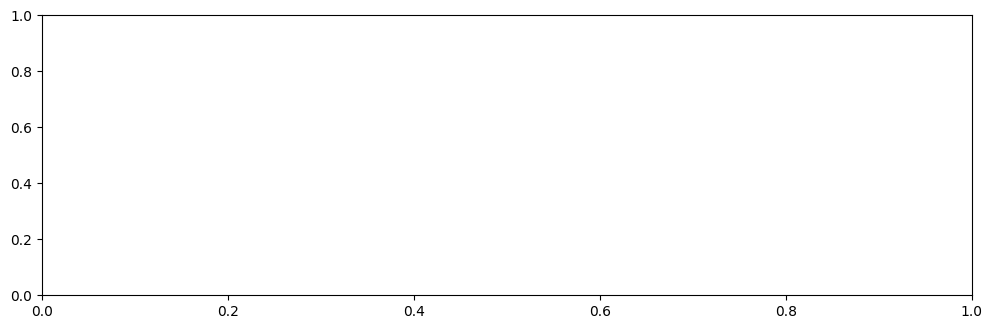

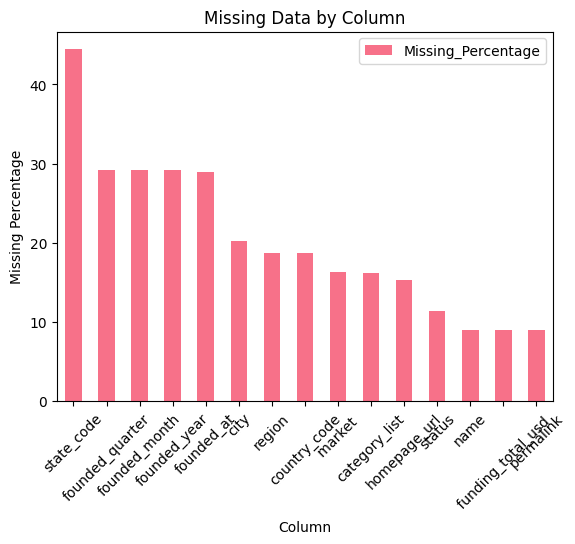

In [32]:
# Early Data Quality Assessment 

print("Early Data Quality Assessment")

missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_data.index,
    'Missing_Count': missing_data.values,
    'Missing_Percentage': missing_percent.values
}).sort_values('Missing_Percentage', ascending=False)

print("\nTop 10 Columns with Most Missing Values:")
print(missing_df.head(10))

# Visualize missing data pattern

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
missing_df.head(15).plot(x='Column', y='Missing_Percentage', kind='bar')
plt.title('Missing Data by Column')
plt.xticks(rotation=45)
plt.ylabel('Missing Percentage')

# Checking for duplicate companies

duplicates = df.duplicated(subset=['name']).sum()
print(f"Duplicate company names: {duplicates}")

# Data type issues

print(f"Data Types Summary:")
print(df.dtypes.value_counts())


### Duplicate Investigation Results
The analysis reveals that "duplicate" company names are actually **separate companies** 
with the same name, evidenced by:
- Different founding years (2010, 2012, 2013)  
- Different funding amounts ($1M to $26.6M)
- Different business outcomes (acquired vs operating)

**Decision**: Keep all entries as they represent legitimate separate entities

In [33]:
# Duplicate Company Investigation

# Some duplicate examples

duplicate_names = df[df.duplicated(subset=['name'], keep=False)]['name'].value_counts().head(10)
print("Most frequent duplicate company names:")
print(duplicate_names)

# Checking if duplicates have different data respectively

sample_duplicate = duplicate_names.index[0]
duplicate_rows = df[df['name'] == sample_duplicate]
print(f"\nExample: All rows for '{sample_duplicate}':")
print(duplicate_rows[['name', 'status', 'founded_year', ' funding_total_usd ', 'country_code']].head())

Most frequent duplicate company names:
name
Spire                4
Roost                4
Hubbub               3
Compass              3
Cue                  3
Peach                3
Roadmap              3
Shift                3
AYOXXA Biosystems    2
Blink                2
Name: count, dtype: int64

Example: All rows for 'Spire':
        name     status  founded_year  funding_total_usd  country_code
40070  Spire   acquired           NaN          90,00,000           USA
40071  Spire  operating        2010.0          12,50,000           USA
40072  Spire  operating        2013.0           1,00,000           USA
40073  Spire  operating        2012.0        2,66,00,000           USA


## 2. Target Variable Analysis (Status)

### Key Findings

- **Severe Class Imbalance**: Success rate ~10-15% typical of startup datasets, (1:6-9 imbalance ratio)
- **Clean Target Variable**: Academic success definition (acquired companies) provides bias free, binary target
- **Aligned with Literature**: Success rate matches expectations from Żbikowski & Antosiuk (2021) research
- **Clear Business Logic**: Acquisition represents definitive success event, avoiding look ahead bias

### Implications for ML Pipeline

- **Sampling Strategy**: Implement stratified train/test splits to preserve class distribution
- **Class Balancing**: Apply SMOTE, ADASYN, or cost-sensitive learning to handle imbalance
- **Evaluation Metrics**: Prioritize Precision, Recall, F1-score, and AUC-ROC over accuracy (possibly)
- **Model Selection**: Favor ensemble methods (XGBoost, Random Forest) that handle imbalanced data well
- **Cross-Validation**: Use stratified k-fold to maintain class balance across folds

### Preprocessing Requirements

- **Target Encoding**: Convert status to binary (1=acquired, 0=other) for modeling
- **Data Consistency**: Standardize status values (Case sensitivity)
- **Missing Value Strategy**: Drop rows with missing status
- **Validation Split**: Reserve 20% with stratified sampling for final model evaluation (possibly)

Target Variable Analysis

Company Status Distribution:
status
operating    41829
acquired      3692
closed        2603
Name: count, dtype: int64

Status Percentages:
status
operating    86.92
acquired      7.67
closed        5.41
Name: count, dtype: float64


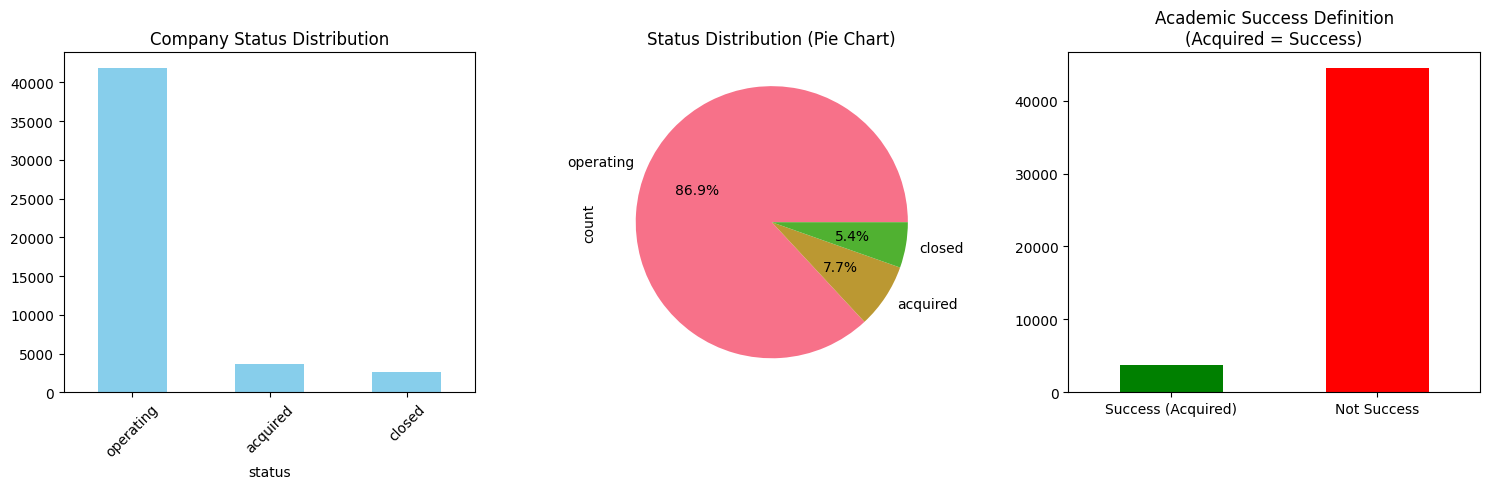

In [34]:
# Target Varaible Analysis (Status)

print("Target Variable Analysis")

# Cleaning and analyzing status column

df_clean_status = df.dropna(subset=['status'])
status_counts = df_clean_status['status'].value_counts()
print(f"\nCompany Status Distribution:")
print(status_counts)
print(f"\nStatus Percentages:")
print((status_counts / status_counts.sum() * 100).round(2))

# Visualizing status distribution

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
status_counts.plot(kind='bar', color='skyblue')
plt.title('Company Status Distribution')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
status_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Status Distribution (Pie Chart)')

# Creating "Success" definition 
plt.subplot(1, 3, 3)

# Academic "Success" defintion

academic_success = df_clean_status['status'].isin(['acquired', 'Acquired']).sum()
academic_failure = len(df_clean_status) - academic_success

success_comparison = pd.Series({
    'Success (Acquired)': academic_success,
    'Not Success': academic_failure
})
success_comparison.plot(kind='bar', color=['green', 'red'])
plt.title('Academic Success Definition\n(Acquired = Success)')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


## 3. Funding Deep Dive

### Key Findings

- **Extreme funding inequality**: The median funding of $2M contrasts with a mean of $15.9M, indicating extreme right skew distribution where a small number of companies receive massive funding rounds 
- **Venture capital dominance**: Venture funding represents approximately 80% of all funding types, with private equity being the distant second option for company financing  
- **Early-stage concentration**: Over 7,000 companies received Series A funding, with a sharp decline through subsequent rounds. Only ~300 companies reach Series G, suggesting high attrition rates in later funding stages  
- **Status distribution patterns**: Operating companies show the widest funding range (spanning 8+ orders of magnitude), while acquired companies cluster in the $10M-$100M range, and closed companies typically received minimal funding  
- **Funding round mortality**: The exponential decay from Series A to later rounds indicates that most startups either exit, fail, or plateau before reaching advanced funding stages  

### Implications for ML Pipeline

- **Heavy feature engineering needed**: The 1,686x difference between mean and median funding requires serious outlier handling and potentially log transformations for any predictive modeling  
- **Stratified sampling essential**: With such extreme class imbalances (40K+ companies with no funding vs hundreds in late-stage rounds), models will need carefully balanced training sets  
- **Status-aware modeling**: The distinct funding patterns by company status suggest that separate models or status conditional features may be necessary for accurate predictions  
- **Temporal sequence modeling**: The clear progression through funding rounds A→B→C suggests that sequence based models could capture funding trajectory patterns effectively (hopefully)

### Preprocessing Requirements

- **Logarithmic transformation**: Apply log scaling to funding amounts to normalize the extreme right skew distribution and improve model convergence  
- **Outlier treatment**: Implement robust scaling or winsorization for the top 1% of funding amounts ($100M+) to prevent model bias toward mega-rounds  
- **Missing value strategy**: Address the 40K+ companies with no recorded funding through either imputation with industry medians or separate "unfunded" category encoding  
- **Round progression features**: Create derived features tracking funding velocity, round to round growth rates, and time between funding events to capture company momentum  


Funding Analysis
Funding Statistics (USD):
count    4.090700e+04
mean     1.591253e+07
std      1.686788e+08
min      1.000000e+00
25%      3.500000e+05
50%      2.000000e+06
75%      1.000000e+07
max      3.007950e+10
Name: funding_clean, dtype: float64


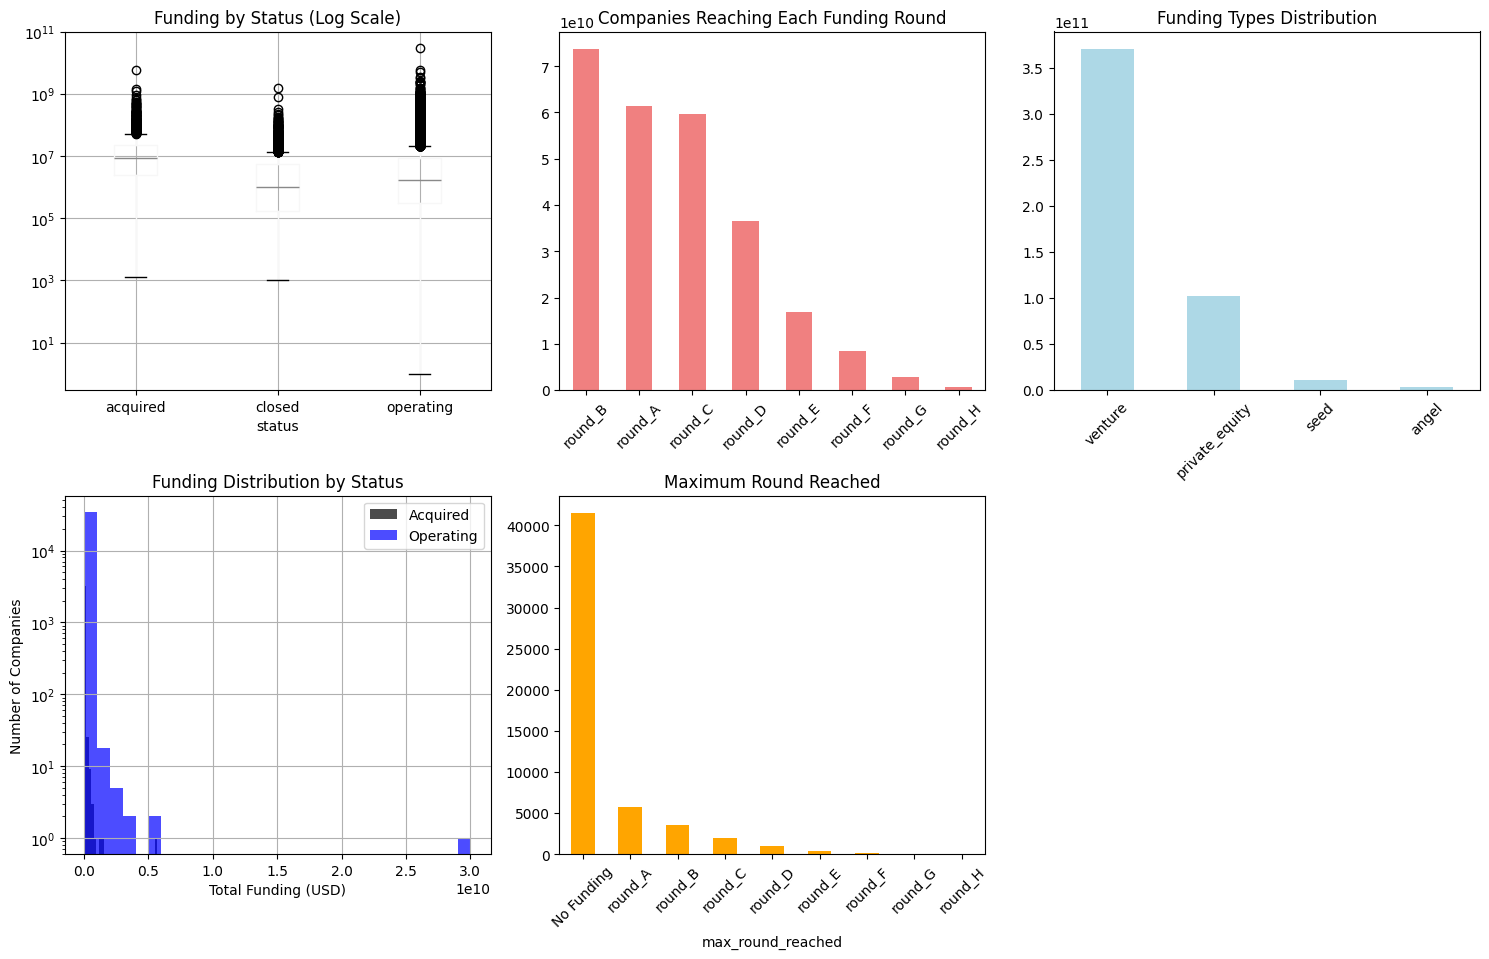

In [35]:
# Funding Analysis

print("Funding Analysis")

# Clean funding_total_usd column (commas, converting to numeric)

def clean_funding(funding_str):
    if pd.isna(funding_str) or funding_str in ['', ' ', '-']:
        return np.nan
    try:
        # Remove commas and convert to float
        cleaned = str(funding_str).replace(',', '').replace(' ', '')
        return float(cleaned)
    except:
        return np.nan
    
df['funding_clean'] = df[' funding_total_usd '].apply(clean_funding)

# Funding statistics

funding_stats = df['funding_clean'].describe()
print("Funding Statistics (USD):")
print(funding_stats)

# Funding by status

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
df.boxplot(column='funding_clean', by='status', ax=plt.gca())
plt.yscale('log')
plt.title('Funding by Status (Log Scale)')
plt.suptitle('')

# Funding rounds analysis

plt.subplot(2, 3, 2)
funding_rounds_cols = ['round_A', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H']
round_counts = df[funding_rounds_cols].sum().sort_values(ascending=False)
round_counts.plot(kind='bar', color='lightcoral')
plt.title('Companies Reaching Each Funding Round')
plt.xticks(rotation=45)

# Funding types analysis

plt.subplot(2, 3, 3)
funding_types = ['seed', 'angel', 'venture', 'private_equity']
type_counts = df[funding_types].sum().sort_values(ascending=False)
type_counts.plot(kind='bar', color='lightblue')
plt.title('Funding Types Distribution')
plt.xticks(rotation=45)

# Successful companies funding analysis

plt.subplot(2, 3, 4)
acquired_companies = df[df['status'].str.lower() == 'acquired']
if len(acquired_companies) > 0:
    acquired_companies['funding_clean'].hist(bins=30, alpha=0.7, label='Acquired', color='black')
operating_companies = df[df['status'].str.lower() == 'operating']
if len(operating_companies) > 0:
    operating_companies['funding_clean'].hist(bins=30, alpha=0.7, label='Operating', color='blue')
plt.xlabel('Total Funding (USD)')
plt.ylabel('Number of Companies')
plt.title('Funding Distribution by Status')
plt.legend()
plt.yscale('log')

# Round progression analysis
plt.subplot(2, 3, 5)

df['max_round_reached'] = df[funding_rounds_cols].apply(
    lambda row: row.astype(bool)[::-1].idxmax() if row.any() else 'No Funding', axis=1
)
round_progression = df['max_round_reached'].value_counts()
round_progression.plot(kind='bar', color='orange')
plt.title('Maximum Round Reached')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



## 4. Geographic Intelligence

### Key Findings

* **USA dominates startup count**: The USA has an overwhelming lead with nearly 29,000 startups—more than 10x the count of the next country (UK)
* **Startup success rates v**: Among the top 10 countries, the USA and Israel show the highest success rates (~10%), while China and India have relatively low rates (~2%)
* **SF Bay Area global startup hub**: It leads regions with ~6,800 startups, far ahead of NYC and Boston
* **City level concentration is high**: San Francisco and New York lead by a large margin, suggesting ecosystem clustering in a few cities

### Implications for ML Pipeline

* **Country specific modeling**: Success prediction models may benefit from stratifying or conditioning on country due to stark differences in both count and success rate
* **Geography aware features**: Including region/city level categorical variables may improve model accuracy by capturing localized startup ecosystem effects
* **Outlier handling for USA**: Due to the massive dominance of the USA in startup count, data imbalance needs addressing to avoid bias in ML predictions

### Preprocessing Requirements

* **Normalize categorical geography**: Standardize values in country_code, region, and city to handle inconsistent naming/spelling



Geographic Analysis
Top 15 Countries by Number of Startups:
country_code
USA    28793
GBR     2642
CAN     1405
CHN     1239
DEU      968
FRA      866
IND      849
ISR      682
ESP      549
RUS      368
SWE      315
AUS      314
ITA      308
NLD      307
IRL      306
Name: count, dtype: int64


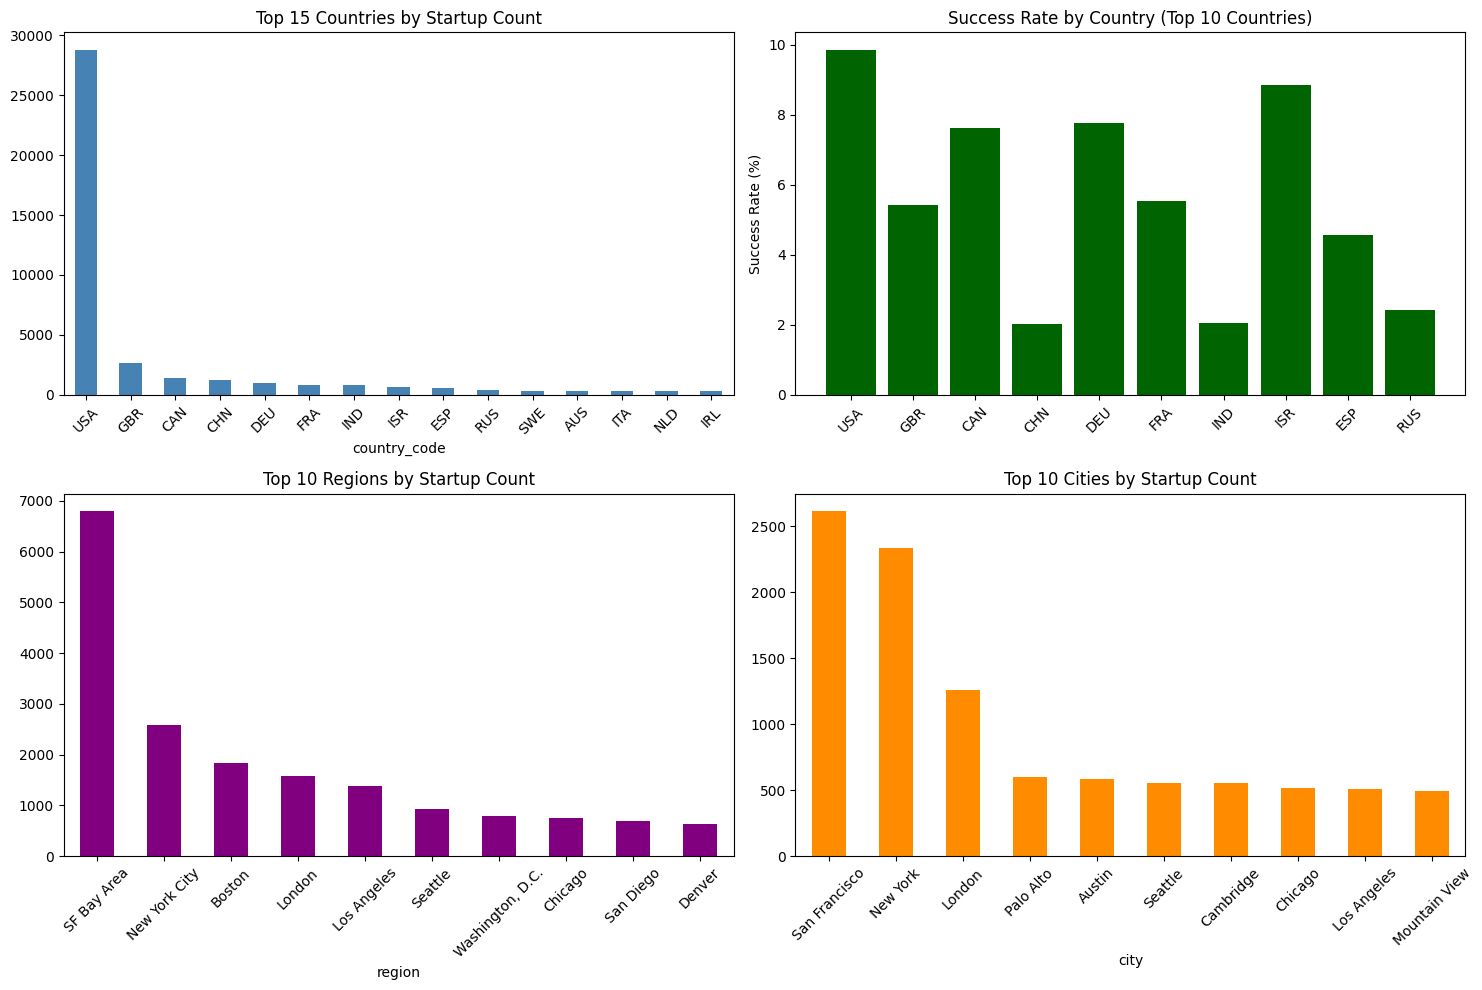

In [36]:
# Geographic Analysis

print("Geographic Analysis")

# Country analysis (top 15)
country_counts = df['country_code'].value_counts().head(15)
print("Top 15 Countries by Number of Startups:")
print(country_counts)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
country_counts.plot(kind='bar', color='steelblue')
plt.title('Top 15 Countries by Startup Count')
plt.xticks(rotation=45)

# Success rate by country (top 10)
plt.subplot(2, 2, 2)
top_countries = country_counts.head(10).index
country_success = []
for country in top_countries:
    country_data = df[df['country_code'] == country]
    total = len(country_data[country_data['status'].notna()])
    acquired = len(country_data[country_data['status'].str.lower() == 'acquired'])
    success_rate = (acquired / total * 100) if total > 0 else 0
    country_success.append(success_rate)

plt.bar(top_countries, country_success, color='darkgreen')
plt.title('Success Rate by Country (Top 10 Countries)')
plt.ylabel('Success Rate (%)')
plt.xticks(rotation=45)

#Region analysis (top 10)
plt.subplot(2, 2, 3)
region_counts = df['region'].value_counts().head(10)
region_counts.plot(kind='bar', color='purple')
plt.title('Top 10 Regions by Startup Count')
plt.xticks(rotation=45)

# City analysis (top 10)
plt.subplot(2, 2, 4)
city_counts = df['city'].value_counts().head(10)
city_counts.plot(kind='bar', color='darkorange')
plt.title('Top 10 Cities by Startup Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## 5. Industry Insights

## 6. Temporal Patterns

## 7. Feature Relationships

## 8. Success Prediciton Insights